This notebooks assigns a graph node to every Bicing station and saves the dataset as a csv.

---
Author: Jordi Grau Escolano


# 1. Load data

In [1]:
import sys
from pathlib import Path
from shapely import wkt
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import contextily as ctx
import osmnx as ox

# Add project root to path
project_root = Path().resolve().parents[0]
sys.path.insert(0, str(project_root))
ROOT = "../"

from paths import *
import src.data_loader as dl
import src.optimization.experiments.helper_experiment as he
import src.optimization.helper_optimization as ho

df, G, distance_matrix, id_to_idx, idx_to_id, _, STATION_MIN_DISTANCE = he.load_data(root=ROOT)
# df_stations = pd.read_csv(f'{ROOT}/{PR_EXP}/BSS_ampliation/bicing_stations_no_eixample.csv')
city_boundary = dl.load_bcn_boundary()

	Successfully loaded graph bike_graph with protocol 5
Loading existing node attributes from ..//data/processed/nodes/node_attributes.csv
Loading pre-computed distance matrix and mappings...
	Successfully loaded mappings with protocol 5
Successfully loaded distance matrix of shape (18721, 18721)


Codi_Districte nom_districte  \
0               1  Ciutat Vella   
1               2      Eixample   

                                    geometria_etrs89  \
0  POLYGON ((431735.899600634 4582445.23444175, 4...   
1  POLYGON ((432035.336202865 4583668.43902139, 4...   

                                     geometria_wgs84  
0  POLYGON ((431735.9 4582445.234, 431647.257 458...  
1  POLYGON ((432035.336 4583668.439, 432035.338 4...

In [4]:
# Load districtes
df_districtes = pd.read_csv(f'{ROOT}/{RAW_BCN}/BarcelonaCiutat_Districtes.csv')
df_districtes['geometria_wgs84'] = df_districtes['geometria_wgs84'].apply(wkt.loads)
df_districtes = gpd.GeoDataFrame(df_districtes, geometry='geometria_wgs84', crs='EPSG:4326')
df_districtes = df_districtes.to_crs('EPSG:25831')
df_districtes.head(2)

# Load Bicing stations data. Needs to be cleaned.
df_stations = pd.read_csv(f'{ROOT}/{RAW_BCN}/2025_01_Gener_BicingNou_INFORMACIO.csv')
df_stations.drop(columns=[  # Unnecessary columns
    'address', 'cross_street', 'post_code', 'capacity', 'is_charging_station', 
    'short_name', 'nearby_distance', 'x_ride_code_support', 'rental_uris',
    'is_valet_station', 'last_updated', 'ttl', 'V1'], inplace=True)
df_stations.dropna(subset=['station_id'], inplace=True) #  some empty rows
df_stations['station_id'] = df_stations['station_id'].apply(int)

# Get unique stations with latitude and longitude
df_stations = df_stations.groupby(['station_id', 'lat','lon']).size().reset_index(name='count')
df_stations = df_stations.sort_values(by='count', ascending=False)
df_stations.drop(columns=['count'], inplace=True)
df_stations.drop_duplicates(inplace=True)

# Convert to GeoDataFrame
df_stations = gpd.GeoDataFrame(df_stations, geometry=gpd.points_from_xy(df_stations['lon'], df_stations['lat']), crs='EPSG:4326')
df_stations = df_stations.to_crs('EPSG:25831')

# Drop specific lat/lon combinations. Some stations have multiple lat/lon values. Visually checked.
rows_id_to_drop = [54, 250, 249, 374]
mask = ~df_stations.apply(lambda x: (x.name) in rows_id_to_drop, axis=1)
df_stations = df_stations[mask]

/tmp/ipykernel_27912/299903378.py:9: DtypeWarning: Columns (10,13) have mixed types. Specify dtype option on import or set low_memory=False.
  df_stations = pd.read_csv(f'{ROOT}/{RAW_BCN}/2025_01_Gener_BicingNou_INFORMACIO.csv')


# 2. Remove stations inside the l'Eixample district

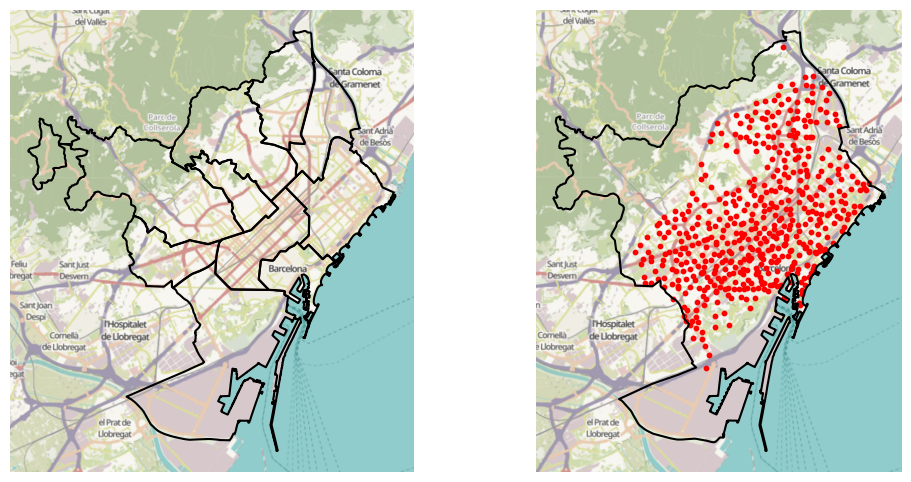

In [7]:
# Plot districtes
fig, ax = plt.subplots(1,2, figsize=(12, 6))
df_districtes.boundary.plot(ax=ax[0], markersize=10, color='black')
ctx.add_basemap(ax[0], crs=df_districtes.crs, zoom=12, attribution=False)
ax[0].axis('off')

# Plot stations
df_stations.plot(ax=ax[1], color='red', markersize=10)
city_boundary.boundary.plot(ax=ax[1], color='black', markersize=10)
ctx.add_basemap(ax[1], crs=city_boundary.crs, zoom=12, attribution=False)
ax[1].axis('off')
plt.show()

Original station count: 518
Station count after removing Eixample district: 410
Removed 108 stations inside of Eixample district


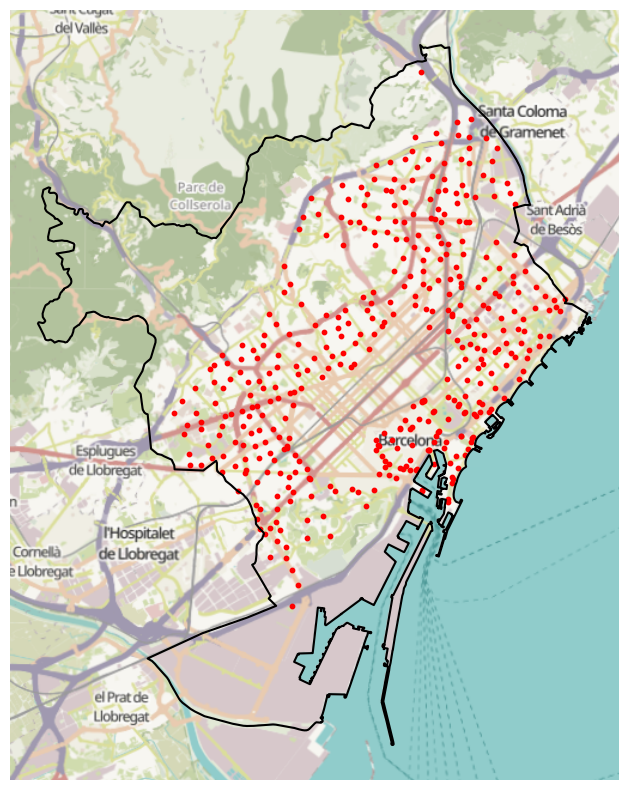

In [29]:
# Remove stations inside of eixample district
original_station_count = len(df_stations)
eixample = df_districtes[df_districtes['nom_districte'] == 'Eixample']
df_stations = df_stations[df_stations.geometry.disjoint(eixample.geometry.iloc[0])]
print(f"Original station count: {original_station_count}")
print(f"Station count after removing Eixample district: {len(df_stations)}")
print(f"Removed {original_station_count - len(df_stations)} stations inside of Eixample district")

# Plot stations
fig, ax = plt.subplots(figsize=(10, 10))
df_stations.plot(ax=ax, color='red', markersize=10)
city_boundary.boundary.plot(ax=ax, color='black', markersize=10)
ctx.add_basemap(ax, crs=city_boundary.crs, zoom=12, attribution=False)
ax.axis('off')
plt.show()

# 3. Assign to each station a graph node

This assignation will allow to put into the optimazion algorithm where there are stations already.


Distance statistics (in meters):
Mean distance: 27.17
Median distance: 24.16
Min distance: 2.10
Max distance: 185.72
Standard deviation: 18.26


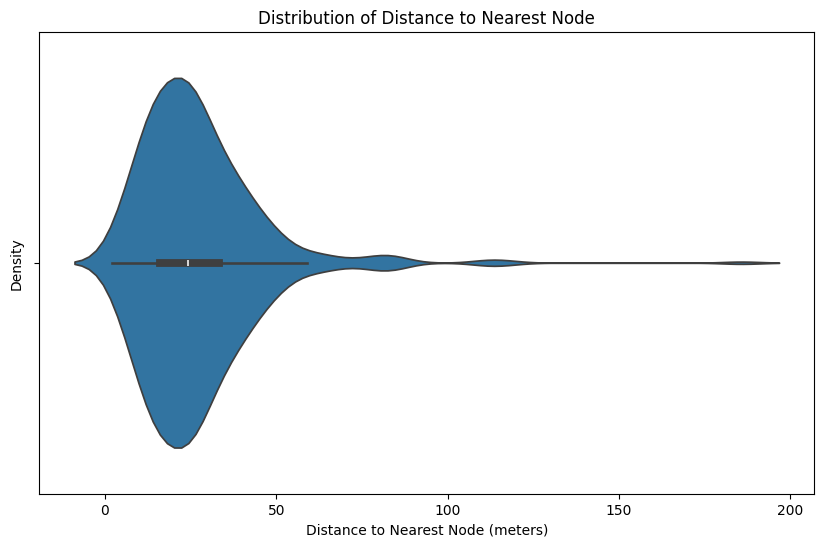

count    410.000000
mean      27.171479
std       18.255716
min        2.097968
25%       15.986442
50%       24.163330
75%       33.357951
max      185.724167
Name: distance_to_node, dtype: float64


station_id        lat       lon                        geometry  \
8             9  41.384546  2.184922  POINT (431850.354 4581767.224)   
521         544  41.370490  2.148729   POINT (428808.86 4580235.844)   

     nearest_node_id  distance_to_node  
8          219011772         11.335540  
521        178514518         17.814063

In [30]:
# Find nearest node in df for each station
nearest_nodes = []
nearest_distances = []
for station_geom in df_stations.geometry:
    # Calculate distances from this station to all nodes
    distances = df.geometry.distance(station_geom)
    # Get index of minimum distance
    nearest_idx = distances.idxmin()
    nearest_nodes.append(nearest_idx)
    # Save the minimum distance
    nearest_distances.append(distances.min())

# Add nearest node info and distances to df_stations
df_stations['nearest_node_id'] = df.iloc[nearest_nodes]['node_id'].values
df_stations['distance_to_node'] = nearest_distances

# Print distance statistics
print("\nDistance statistics (in meters):")
print(f"Mean distance: {df_stations['distance_to_node'].mean():.2f}")
print(f"Median distance: {df_stations['distance_to_node'].median():.2f}")
print(f"Min distance: {df_stations['distance_to_node'].min():.2f}")
print(f"Max distance: {df_stations['distance_to_node'].max():.2f}")
print(f"Standard deviation: {df_stations['distance_to_node'].std():.2f}")

# Violinplot
plt.figure(figsize=(10, 6))
sns.violinplot(x='distance_to_node', data=df_stations)
plt.title('Distribution of Distance to Nearest Node')
plt.xlabel('Distance to Nearest Node (meters)')
plt.ylabel('Density')
plt.show()

print(df_stations['distance_to_node'].describe())

df_stations.head(2)

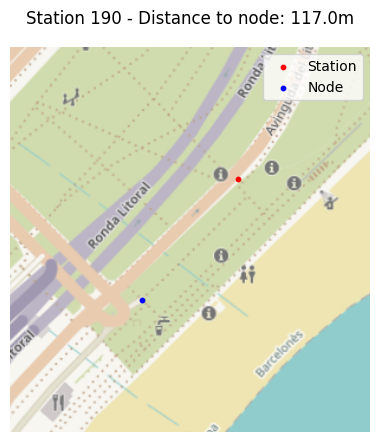

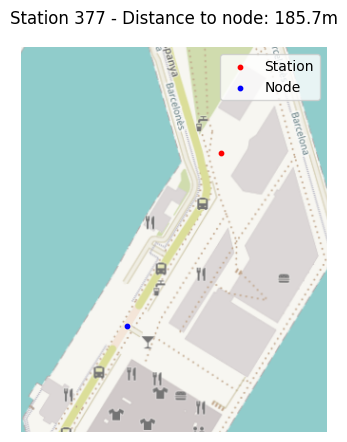

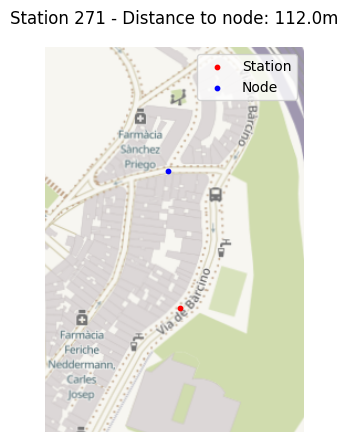

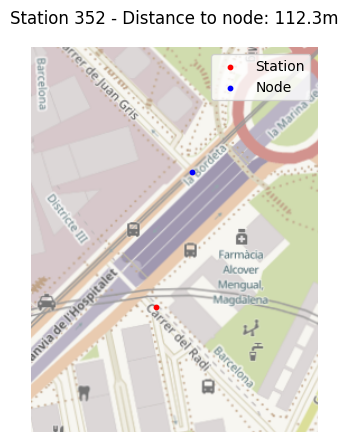

In [31]:
# Filter stations that are 50m or more from nearest node
far_stations = df_stations[df_stations['distance_to_node'] >= 100]

for _, station in far_stations.iterrows():
    fig, ax = plt.subplots(figsize=(5, 5))
    
    # Get corresponding node
    node = df[df['node_id'] == station['nearest_node_id']]
    
    city_boundary = dl.load_bcn_boundary()
    # Plot station and node
    station_gdf = gpd.GeoDataFrame([station], geometry='geometry')
    station_gdf.plot(ax=ax, color='red', markersize=10)
    node.plot(ax=ax, color='blue', markersize=10)
    
    # Set limits 100m around station point
    # Get station and node coordinates
    station_x = station.geometry.x
    station_y = station.geometry.y
    node_x = node.geometry.iloc[0].x
    node_y = node.geometry.iloc[0].y
    
    # Set limits to include both station and node with padding
    min_x = min(station_x, node_x) - 100
    max_x = max(station_x, node_x) + 100
    min_y = min(station_y, node_y) - 100
    max_y = max(station_y, node_y) + 100
    
    ax.set_xlim(min_x, max_x)
    ax.set_ylim(min_y, max_y)
    ax.legend(['Station', 'Node'], loc='upper right')
    
    ctx.add_basemap(ax, crs=city_boundary.crs, zoom=17, attribution=False)
    ax.axis('off')
    
    plt.title(f"Station {station['station_id']} - Distance to node: {station['distance_to_node']:.1f}m")
    plt.show()

In [ ]:
# There are some nodes that are assigned to multiple stations. We need to handle this.
near_nodes = df_stations.groupby([ 'nearest_node_id']).size().sort_values(ascending=False).reset_index(name='count')
reused_nodes = near_nodes[near_nodes['count'] > 1 ]
reused_nodes_ids = reused_nodes['nearest_node_id'].values
reused_nodes

nearest_node_id  count
0       10308954439      3
1         216321612      2
2        1141475341      2
3        4111688786      2
4         876277535      2
5        4229014410      2
6         870495187      2
7        9250200867      2
8        9250200864      2
9         219011772      2
10         21638855      2

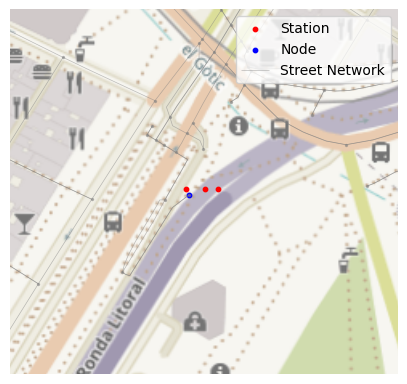

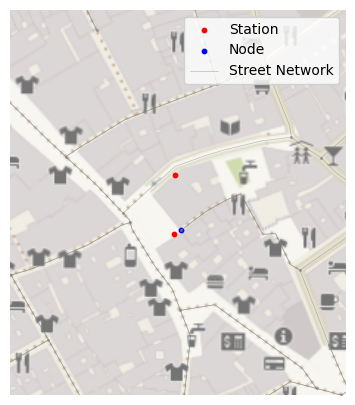

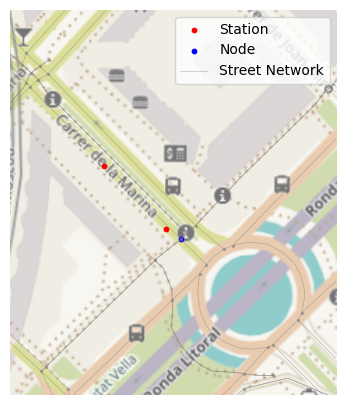

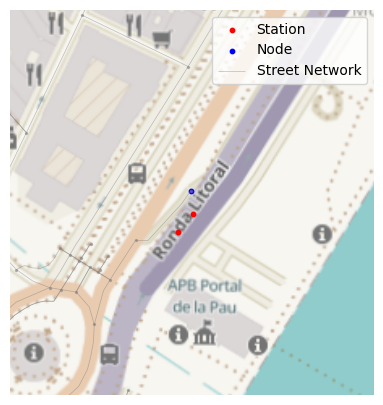

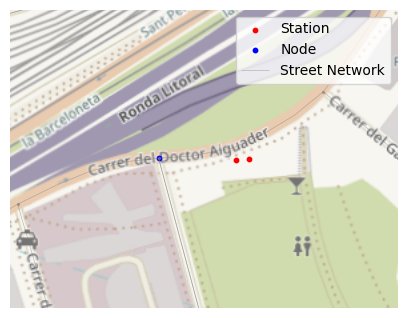

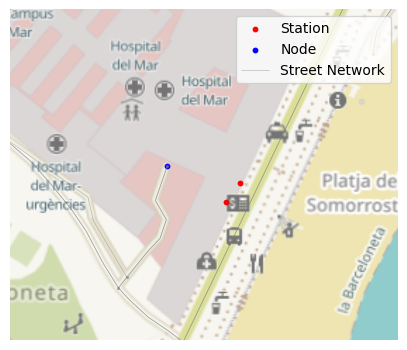

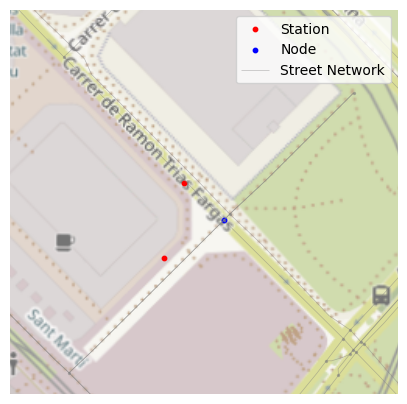

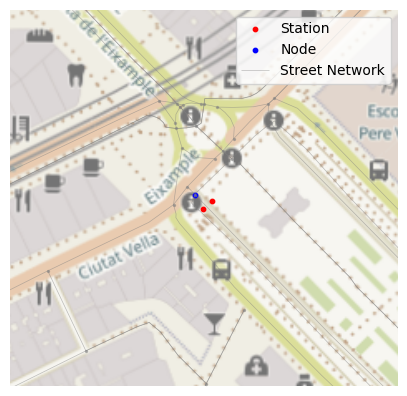

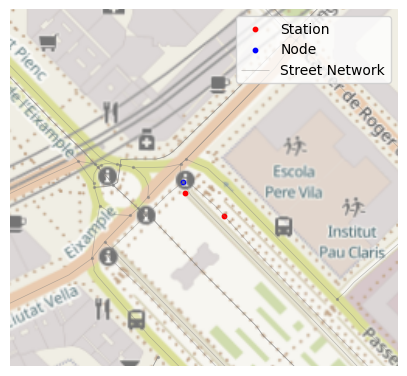

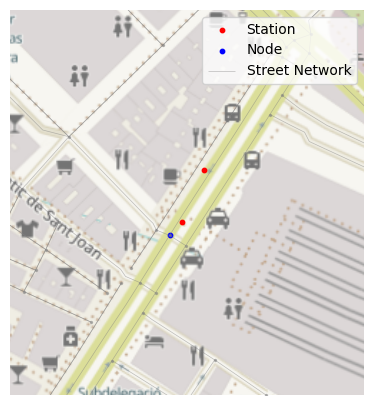

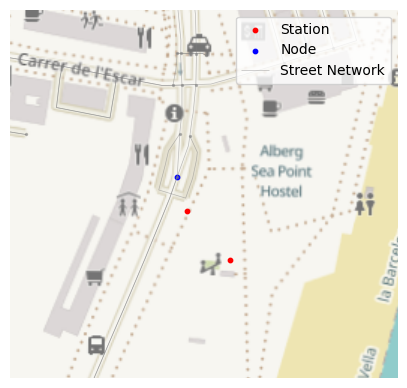

In [ ]:
# Plot the reused nodes
for reused_node_id in reused_nodes_ids:
    fig, ax = plt.subplots(figsize=(5, 5))
    
    # Get corresponding nodes
    reused_node_data = df[df['node_id'] == reused_node_id]
    reused_node_gdf = gpd.GeoDataFrame(reused_node_data, crs=city_boundary.crs)
    stations_data = df_stations[df_stations['nearest_node_id'] == reused_node_id]
    stations_gdf = gpd.GeoDataFrame(stations_data, crs=city_boundary.crs)
    
    # Plot station and node
    stations_gdf.plot(ax=ax, color='red', markersize=10)
    reused_node_gdf.plot(ax=ax, color='blue', markersize=10)
    
    # Set limits 100m around station point
    # Get station and node coordinates
    station_x = stations_gdf.geometry.x.values.max()
    station_y = stations_gdf.geometry.y.values.max()
    node_x = reused_node_gdf.geometry.iloc[0].x
    node_y = reused_node_gdf.geometry.iloc[0].y
    
    # Set limits to include both station and node with padding
    min_x = min(station_x, node_x) - 100
    max_x = max(station_x, node_x) + 100
    min_y = min(station_y, node_y) - 100
    max_y = max(station_y, node_y) + 100
    
    # Get nodes and edges within limits
    # bbox format for OSMnx is (south, west, north, east)
    bbox = (min_y, min_x, max_y, max_x)
    
    # Get nodes within bbox
    nodes_in_bbox = []
    for node, data in G.nodes(data=True):
        if ('y' in data and 'x' in data and 
            min_y-200<= data['y'] <= max_y+200 and 
            min_x-200 <= data['x'] <= max_x+200):
            nodes_in_bbox.append(node)
    
    # Create subgraph from nodes in bbox
    subgraph = G.subgraph(nodes_in_bbox).copy()
    
    # Plot network
    nodes, edges = ox.graph_to_gdfs(subgraph)
    edges.plot(ax=ax, color='gray', linewidth=0.5, alpha=0.5)
    nodes.plot(ax=ax, color='gray', markersize=2, alpha=0.5)
    
    ax.set_xlim(min_x, max_x)
    ax.set_ylim(min_y, max_y)
    ax.legend(['Station', 'Node', 'Street Network'], loc='upper right')
    
    ctx.add_basemap(ax, crs=city_boundary.crs, zoom=17, attribution=False)
    ax.axis('off')
    
    # plt.title(f"Station {station['station_id']} - Distance to node: {station['distance_to_node']:.1f}m")
    plt.show()


Distance statistics (in meters):
Mean distance: 27.17
Median distance: 24.16
Min distance: 2.10
Max distance: 185.72
Standard deviation: 18.26


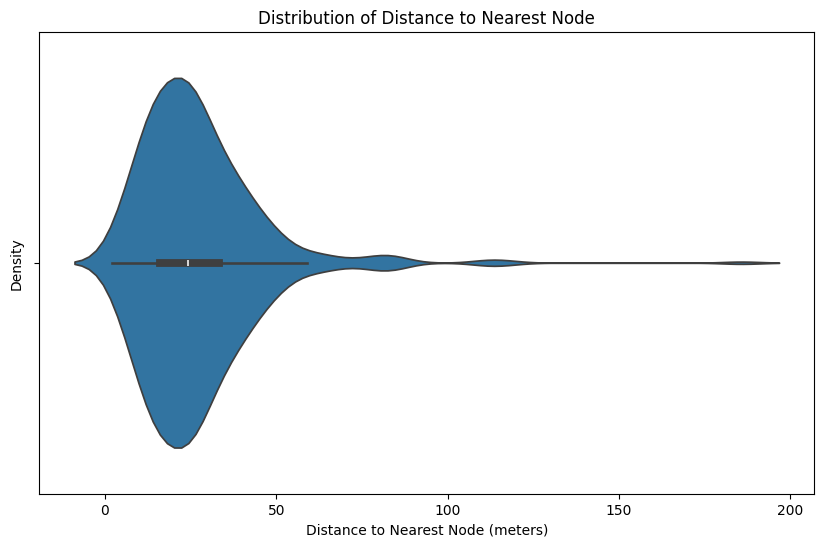

count    410.000000
mean      27.171479
std       18.255716
min        2.097968
25%       15.986442
50%       24.163330
75%       33.357951
max      185.724167
Name: distance_to_node, dtype: float64


station_id        lat       lon                        geometry  \
8             9  41.384546  2.184922  POINT (431850.354 4581767.224)   
521         544  41.370490  2.148729   POINT (428808.86 4580235.844)   

     nearest_node_id  distance_to_node  
8          219011772         11.335540  
521        178514518         17.814063

In [34]:
# Find nearest node in df for each station
nearest_nodes = []
nearest_distances = []
for station_geom in df_stations.geometry:
    # Calculate distances from this station to all nodes
    distances = df.geometry.distance(station_geom)
    # Get index of minimum distance
    nearest_idx = distances.idxmin()
    nearest_nodes.append(nearest_idx)
    # Save the minimum distance
    nearest_distances.append(distances.min())

# Add nearest node info and distances to df_stations
df_stations['nearest_node_id'] = df.iloc[nearest_nodes]['node_id'].values
df_stations['distance_to_node'] = nearest_distances

# Print distance statistics
print("\nDistance statistics (in meters):")
print(f"Mean distance: {df_stations['distance_to_node'].mean():.2f}")
print(f"Median distance: {df_stations['distance_to_node'].median():.2f}")
print(f"Min distance: {df_stations['distance_to_node'].min():.2f}")
print(f"Max distance: {df_stations['distance_to_node'].max():.2f}")
print(f"Standard deviation: {df_stations['distance_to_node'].std():.2f}")

# Violinplot
plt.figure(figsize=(10, 6))
sns.violinplot(x='distance_to_node', data=df_stations)
plt.title('Distribution of Distance to Nearest Node')
plt.xlabel('Distance to Nearest Node (meters)')
plt.ylabel('Density')
plt.show()

print(df_stations['distance_to_node'].describe())

df_stations.head(2)


Reassignment statistics:
Number of stations that needed reassignment: 23
Number of unique nodes in final assignment: 410
Number of stations: 410

Distance statistics comparison (in meters):
Original distances:
count    410.000000
mean      27.171479
std       18.255716
min        2.097968
25%       15.986442
50%       24.163330
75%       33.357951
max      185.724167
Name: distance_to_node, dtype: float64

New distances after reassignment:
count    410.000000
mean      27.476616
std       18.654322
min        2.097968
25%       16.001859
50%       24.169264
75%       33.702191
max      185.724167
Name: final_distance_to_node, dtype: float64


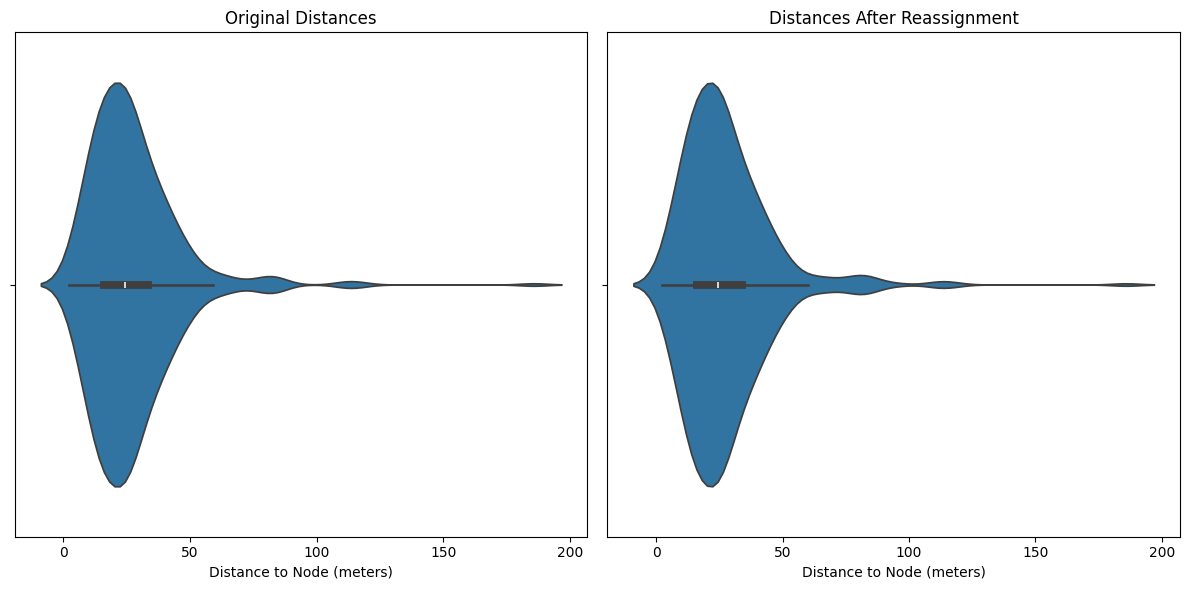

In [35]:
# Find nodes that are assigned to multiple stations
node_counts = df_stations['nearest_node_id'].value_counts()
reused_nodes = node_counts[node_counts >= 2].index

# For each reused node, keep only the closest station and reassign others
assigned_nodes = set()  # Keep track of already assigned nodes
final_assignments = {}  # Store final node assignments for each station

# First, handle stations with unique nodes (keep their assignments)
unique_stations = df_stations[~df_stations['nearest_node_id'].isin(reused_nodes)]
for idx, row in unique_stations.iterrows():
    assigned_nodes.add(row['nearest_node_id'])
    final_assignments[idx] = row['nearest_node_id']

# Then handle stations with reused nodes
reused_stations = df_stations[df_stations['nearest_node_id'].isin(reused_nodes)]
# Sort by distance to ensure closest stations get priority
reused_stations = reused_stations.sort_values('distance_to_node')

for idx, station in reused_stations.iterrows():
    if station['nearest_node_id'] not in assigned_nodes:
        # If the closest node is still available, use it
        assigned_nodes.add(station['nearest_node_id'])
        final_assignments[idx] = station['nearest_node_id']
    else:
        # Find next available nearest node
        distances = df.geometry.distance(station.geometry)
        # Sort distances and find first available node
        sorted_nodes = df.iloc[distances.argsort()]['node_id']
        for node_id in sorted_nodes:
            if node_id not in assigned_nodes:
                assigned_nodes.add(node_id)
                final_assignments[idx] = node_id
                break

# Update df_stations with new assignments
df_stations['final_node_id'] = pd.Series(final_assignments)

# Update distances for new assignments
new_distances = []
for idx, row in df_stations.iterrows():
    node_geom = df[df['node_id'] == row['final_node_id']].geometry.iloc[0]
    distance = row.geometry.distance(node_geom)
    new_distances.append(distance)

df_stations['final_distance_to_node'] = new_distances

# Print statistics about the reassignment
print("\nReassignment statistics:")
print(f"Number of stations that needed reassignment: {len(reused_stations)}")
print(f"Number of unique nodes in final assignment: {len(set(df_stations['final_node_id']))}")
print(f"Number of stations: {len(df_stations)}")

# Compare old and new distances
print("\nDistance statistics comparison (in meters):")
print("Original distances:")
print(df_stations['distance_to_node'].describe())
print("\nNew distances after reassignment:")
print(df_stations['final_distance_to_node'].describe())

# Visualize the comparison
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.violinplot(x='distance_to_node', data=df_stations)
plt.title('Original Distances')
plt.xlabel('Distance to Node (meters)')

plt.subplot(1, 2, 2)
sns.violinplot(x='final_distance_to_node', data=df_stations)
plt.title('Distances After Reassignment')
plt.xlabel('Distance to Node (meters)')

plt.tight_layout()
plt.show()

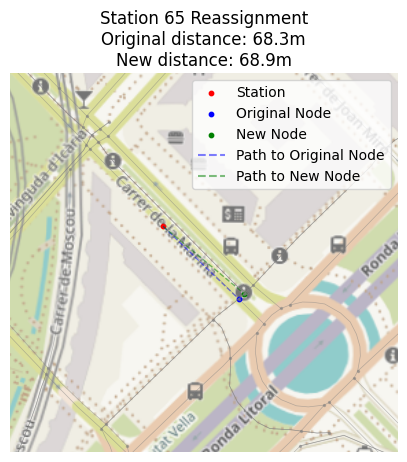

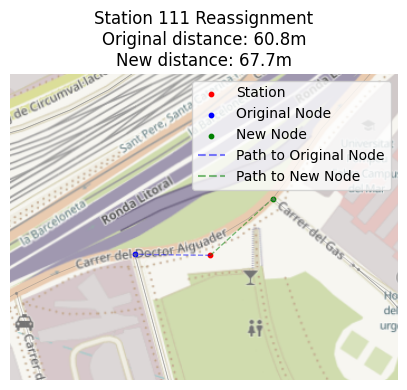

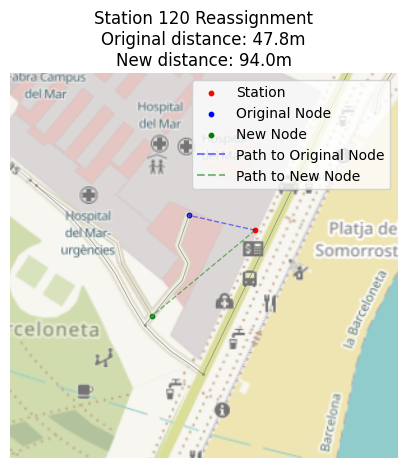

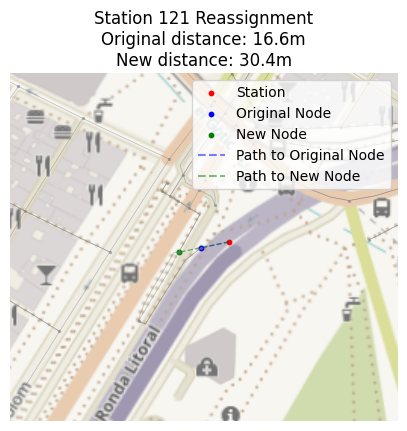

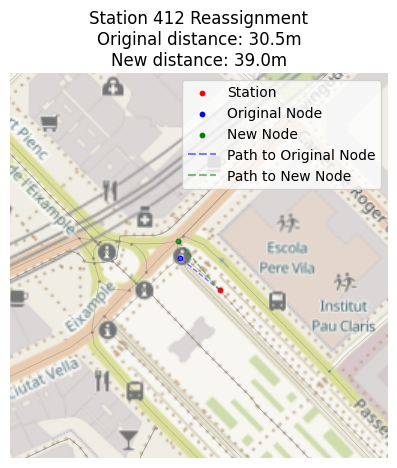

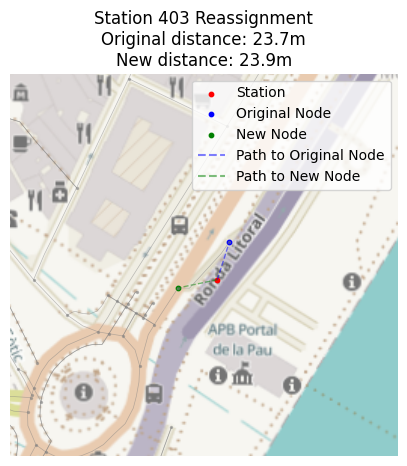

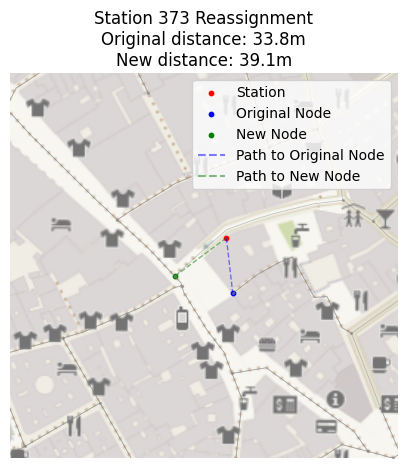

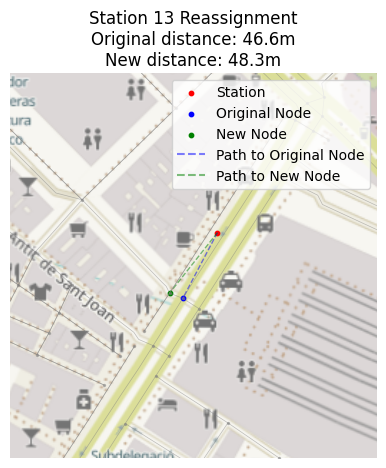

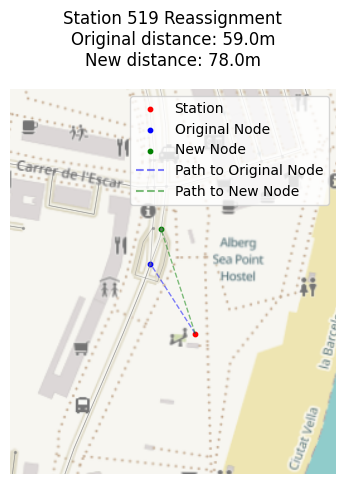

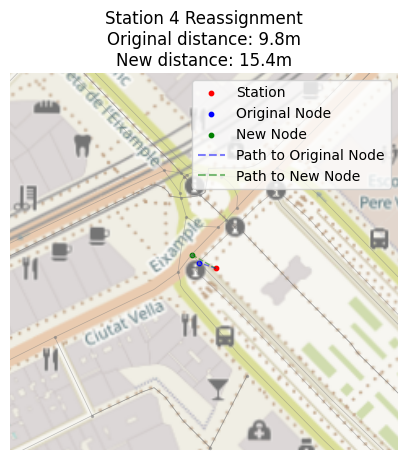

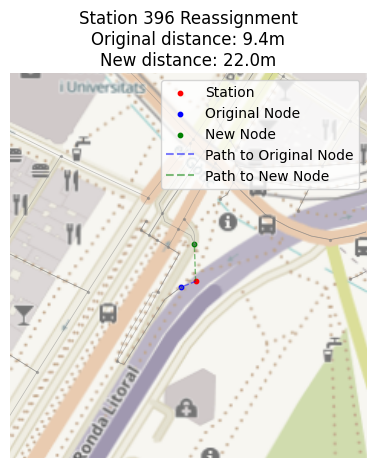

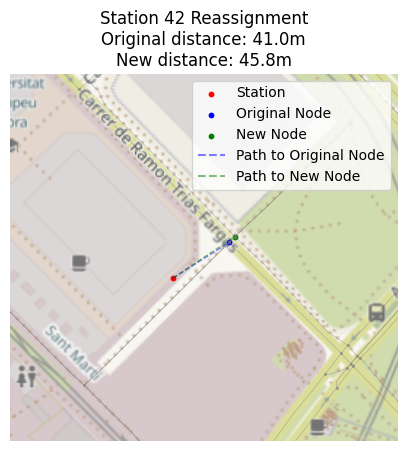

In [36]:
# Get stations that were reassigned (where original and final node are different)
reassigned_stations = df_stations[df_stations['nearest_node_id'] != df_stations['final_node_id']]

for _, station in reassigned_stations.iterrows():
    fig, ax = plt.subplots(figsize=(5, 5))
    
    # Get original and new nodes
    original_node = df[df['node_id'] == station['nearest_node_id']]
    new_node = df[df['node_id'] == station['final_node_id']]
    
    # Create GeoDataFrames
    original_node_gdf = gpd.GeoDataFrame(original_node, crs=city_boundary.crs)
    new_node_gdf = gpd.GeoDataFrame(new_node, crs=city_boundary.crs)
    station_gdf = gpd.GeoDataFrame(pd.DataFrame([station]), crs=city_boundary.crs)
    
    # Plot station and nodes
    station_gdf.plot(ax=ax, color='red', markersize=10, label='Station')
    original_node_gdf.plot(ax=ax, color='blue', markersize=10, label='Original Node')
    new_node_gdf.plot(ax=ax, color='green', markersize=10, label='New Node')
    
    # Draw lines connecting station to both nodes
    x_orig = [station.geometry.x, original_node.geometry.iloc[0].x]
    y_orig = [station.geometry.y, original_node.geometry.iloc[0].y]
    x_new = [station.geometry.x, new_node.geometry.iloc[0].x]
    y_new = [station.geometry.y, new_node.geometry.iloc[0].y]
    
    plt.plot(x_orig, y_orig, 'b--', alpha=0.5, linewidth=1)
    plt.plot(x_new, y_new, 'g--', alpha=0.5, linewidth=1)
    
    # Set limits to include both nodes and station with padding
    all_x = [station.geometry.x, original_node.geometry.iloc[0].x, new_node.geometry.iloc[0].x]
    all_y = [station.geometry.y, original_node.geometry.iloc[0].y, new_node.geometry.iloc[0].y]
    
    min_x = min(all_x) - 100
    max_x = max(all_x) + 100
    min_y = min(all_y) - 100
    max_y = max(all_y) + 100
    
    # Get nodes and edges within limits with extra padding
    bbox = (min_y, min_x, max_y, max_x)
    
    # Get nodes within bbox with extra padding for context
    nodes_in_bbox = []
    for node, data in G.nodes(data=True):
        if ('y' in data and 'x' in data and 
            min_y-200 <= data['y'] <= max_y+200 and 
            min_x-200 <= data['x'] <= max_x+200):
            nodes_in_bbox.append(node)
    
    # Create subgraph from nodes in bbox
    subgraph = G.subgraph(nodes_in_bbox).copy()
    
    # Plot network
    nodes, edges = ox.graph_to_gdfs(subgraph)
    edges.plot(ax=ax, color='gray', linewidth=0.5, alpha=0.5)
    nodes.plot(ax=ax, color='gray', markersize=2, alpha=0.5)
    
    ax.set_xlim(min_x, max_x)
    ax.set_ylim(min_y, max_y)
    
    # Add legend
    handles, labels = ax.get_legend_handles_labels()
    handles.append(plt.Line2D([0], [0], color='blue', linestyle='--', alpha=0.5))
    handles.append(plt.Line2D([0], [0], color='green', linestyle='--', alpha=0.5))
    labels.extend(['Path to Original Node', 'Path to New Node'])
    ax.legend(handles, labels, loc='upper right')
    
    ctx.add_basemap(ax, crs=city_boundary.crs, zoom=17, attribution=False)
    ax.axis('off')
    
    plt.title(f"Station {station.name} Reassignment\nOriginal distance: {station['distance_to_node']:.1f}m\nNew distance: {station['final_distance_to_node']:.1f}m")
    plt.show()

Original station count: 410
Station count after removing Eixample district: 410
Removed 0 stations inside of Eixample district


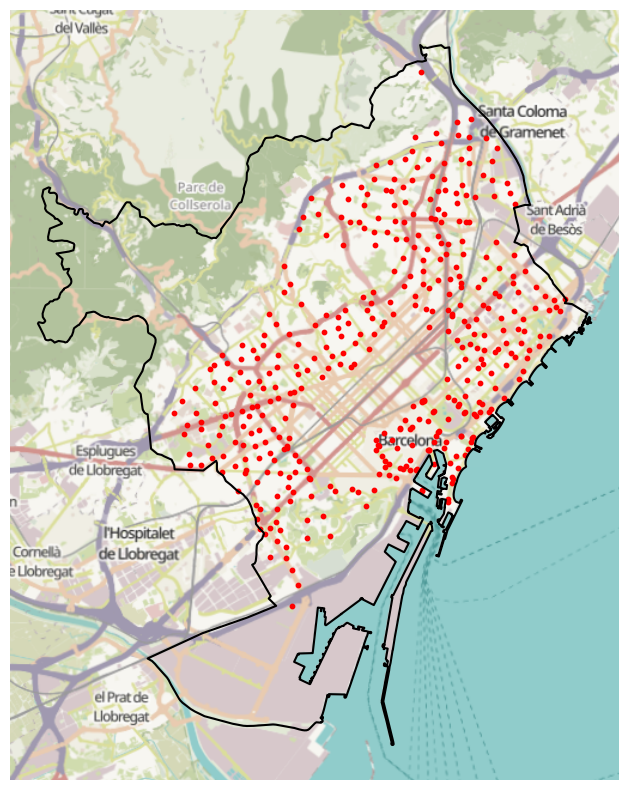

In [37]:
# Remove stations inside of eixample district
original_station_count = len(df_stations)
eixample = df_districtes[df_districtes['nom_districte'] == 'Eixample']
df_stations = df_stations[df_stations.geometry.disjoint(eixample.geometry.iloc[0])]
print(f"Original station count: {original_station_count}")
print(f"Station count after removing Eixample district: {len(df_stations)}")
print(f"Removed {original_station_count - len(df_stations)} stations inside of Eixample district")

# Plot stations
fig, ax = plt.subplots(figsize=(10, 10))
df_stations.plot(ax=ax, color='red', markersize=10)
city_boundary.boundary.plot(ax=ax, color='black', markersize=10)
ctx.add_basemap(ax, crs=city_boundary.crs, zoom=12, attribution=False)
ax.axis('off')
plt.show()

In [38]:
df_stations.to_csv(f'{ROOT}/{PR_EXP}/BSS_ampliation/bicing_stations_no_eixample_reassigned.csv', index=False)